### Bootstrapping

Playground for experimenting with bootstrap methods.

References:
- [ThinkStats2 by AllenDowney](https://github.com/AllenDowney/ThinkStats2)
- [Scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html)
- [Article: "Ditch p-values..."](https://towardsdatascience.com/ditch-p-values-use-bootstrap-confidence-intervals-instead-bba56322b522)
- [Intermediate Statistics with R (Greenwood)](https://stats.libretexts.org/Bookshelves/Advanced_Statistics/Intermediate_Statistics_with_R_(Greenwood)/02%3A_(R)e-Introduction_to_statistics/2.09%3A_Confidence_intervals_and_bootstrapping)
- [StatQuest: "Bootstrapping to calculate p-values"](https://www.youtube.com/watch?v=N4ZQQqyIf6k)

In [136]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from pathlib import Path

Let's start with a simple example of a coin flip. Say a coin is tossed X times with Y heads and Z tails resulting. Can we say whether or not the coin is fair?

Thus the hypotheses for this statistical test are:
- Null Hypothesis: There is *no difference* in coin flip results between this coin and a fair coin.
- Alternative Hypothesis: This *is a difference* in coin flip results between this coin and a fair coin.

In [82]:
# head = 1, tail = 0
heads = [1] * 140
tails = [0] * 110
toss = heads + tails

bootstrap_ci = stats.bootstrap((toss,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=0.496, high=0.62)


A fair coin would have a "true" mean value of 0.5 after a number of tosses. I say "true" in quotes to reference the mean of a population of tosses, rather than the mean of the sample size in this case. The bootstrapped confidence interval tells us that we can be 95% confident that the coin's true mean is between 0.496 and 0.62. Because the 95% confidence interval covers 0.5, we *cannot reject* the null hypothesis that the coin is different from a fair coin. 

**Aside:** I'm attempting to be careful in language here because there is a lot of [confusion](https://en.wikipedia.org/wiki/Confidence_interval#Common_misunderstandings) surrounding the interpretation of confidence intervals (myself included).

**Caveat:** The choice of 95% confidence interval threshold for statistical significance is arbitrary. Such threshold choices should not be considered precise. The best recommendation I've seen is to interpret results based on their order of magnitude. If the test statistic (mean in this case) is outside a 99% confidence interval, the result is unlikely due to chance; if the test statistic is outside a 90% confidence interval, the result is possibly due to chance. Anything within in a 99% to 90% confidence interval band can be considered borderline.

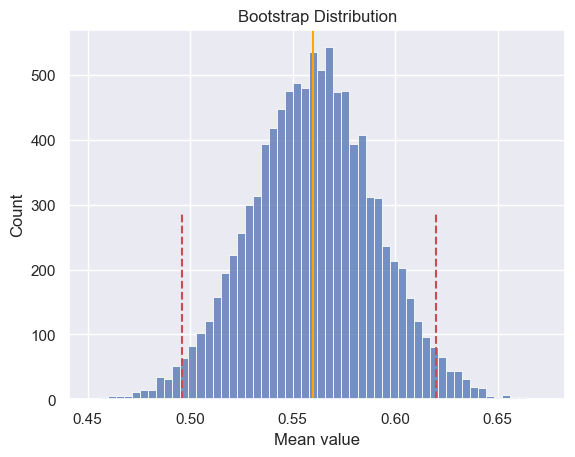

In [83]:
# Visualize the bootstrapped distribution
distribution = bootstrap_ci.bootstrap_distribution
bins = 56
sns.histplot(distribution, bins=bins);
plt.title('Bootstrap Distribution')
plt.xlabel('Mean value')
# show mean and confidence intervals
plt.axvline(np.mean(toss), 0, 1, c='orange', linestyle='-')
ci = bootstrap_ci.confidence_interval
plt.axvline(ci[0], 0, 0.5, c='r', linestyle='--')
plt.axvline(ci[1], 0, 0.5, c='r', linestyle='--')
plt.show()

A bootstrap histogram is an effective visualization for understanding the statistics and expected values. In the plot above, the orange vertical line is the mean from the actual measurement, but it is easy to see all the other possible mean values. Additionally, the red vertical dashed lines represent the bounds for the 95% confidence interval and all mean values outside of the red vertical lines represent results that can be considered statistically significant.

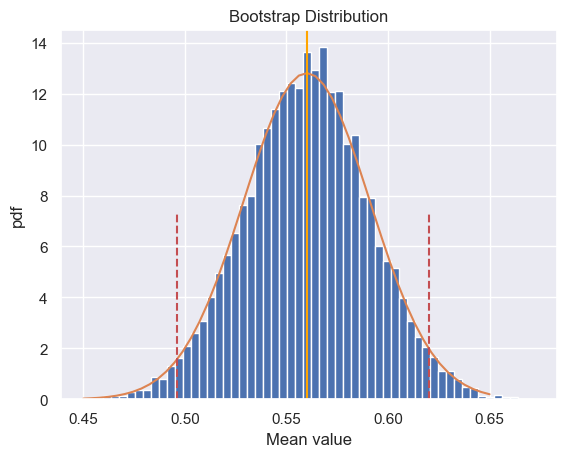

In [84]:
# Same plot with normal distribution overlaid
mean_sample = np.mean(toss)
x = np.linspace(0.45, 0.65)
pdf = stats.norm.pdf(x, loc=mean_sample, scale=bootstrap_ci.standard_error)
plt.hist(distribution, bins=bins, density=True);
plt.title('Bootstrap Distribution')
plt.xlabel('Mean value')
plt.plot(x, pdf)
plt.xlabel('Mean value')
plt.ylabel('pdf')
plt.axvline(np.mean(toss), 0, 1, c='orange', linestyle='-')
plt.axvline(ci[0], 0, 0.5, c='r', linestyle='--')
plt.axvline(ci[1], 0, 0.5, c='r', linestyle='--')
plt.show()

For extra practice, let's calculate the bootstrapped confidence intervals manually for comparison.

In [85]:
np.random.seed(seed=42)
toss_mean = []
for _ in range(9999):
    sample_mean = np.random.choice(toss, size=len(toss), replace=True).mean()
    toss_mean.append(sample_mean)

ci_low = np.quantile(toss_mean, 0.025) 
ci_high = np.quantile(toss_mean, 0.975)
print(ci_low, ci_high)

0.5 0.62


As expected, the result of manually computing the bootstrapped confidence intervals is within three decimal places of the result from scipy's bootstrap method.

Besides confidence intervals, p-values are commonly used and can be calculated form bootstrapping. The general procedure is:
1. Calculate the test statistic (mean in this case) for the original data
2. Shift the original data by some offset such that the statistic is equal to that of the null hypothesis
3. Bootstrap the shifted dataset, which represents a true null hypothesis
4. Use the bootstrapped distribution to calculate the p-value for observing the original statistical value (from step 1) or values more extreme.

In [86]:
null_mean = 0.5
# mean of the original data
toss_mean = np.mean(toss)
offset = toss_mean - null_mean
print(f'Offset value: {offset}')
# dataset representing true null hypothesis
toss_null = toss - offset

Offset value: 0.06000000000000005


ConfidenceInterval(low=0.4319999999999999, high=0.5559999999999999)


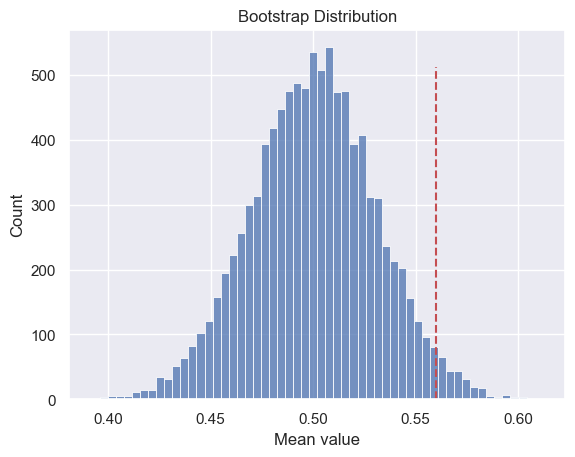

In [110]:
bootstrap_ci = stats.bootstrap((toss_null,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')
print(bootstrap_ci.confidence_interval)

# Visualize the bootstrapped distribution
distribution = bootstrap_ci.bootstrap_distribution
bins = 56
sns.histplot(distribution, bins=bins);
plt.title('Bootstrap Distribution')
plt.xlabel('Mean value')
plt.axvline(toss_mean, 0, 0.9, c='r', linestyle='--');

Histogram shows the distribution for a fair coin. Red dotted line represents the observed mean value from the original dataset.

In [90]:
# Probability of observing the original mean value or more extreme
extreme_counts = ((distribution >= (null_mean + offset)).sum() +
                  (distribution <= (null_mean - offset)).sum())
p_value = extreme_counts / len(distribution)
print(f'p-value: {p_value:.4f}')

p-value: 0.0566


The p-value is greater than 0.5, thus we *fail to reject* the null hypothesis that the coin is fair. This matches the previous result using confidence intervals as expected.

### Difference in Means
Next let's try comparing two groups of data. We'll use the [2002 NSFG Cycle 6](https://www.cdc.gov/nchs/nsfg/nsfg_cycle6.htm) data for pregnancy lengths and compare lengths (in weeks) for first babies and other babies.
- Null hypothesis: There is no difference in pregnancy length for first babies versus other babies.

In [93]:
firstpreg = np.load(Path('firstpreg.npy'))
otherpreg = np.load(Path('otherpreg.npy'))

In [212]:
print(f'Array lengths: {len(firstpreg)} and {len(otherpreg)}')
print(f'First pregnancy mean length (weeks): {firstpreg.mean():.3f}')
print(f'Other pregnancy mean length (weeks): {otherpreg.mean():.3f}')

Array lengths: 4413 and 4735
First pregnancy mean length (weeks): 38.601
Other pregnancy mean length (weeks): 38.523


In [101]:
# First babies
bootstrap_ci = stats.bootstrap((firstpreg,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=38.51642873328801, high=38.68238146921524)


In [102]:
# Other babies
bootstrap_ci = stats.bootstrap((otherpreg,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=38.447135519152624, high=38.594720168954595)


In [213]:
def p_value(data, null_mean):
    '''
    Compute p-value by shifting the dataset to create a dataset
    representing the null hypothesis.
    '''
    offset = np.mean(data) - null_mean
    # TODO
    if offset < 0:
        raise ValueError('Null mean must be smaller than data mean')
    null_data = data - offset

    bootstrap_ci = stats.bootstrap((null_data,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')

    distribution = bootstrap_ci.bootstrap_distribution

    extreme_counts = ((distribution >= (null_mean + offset)).sum() +
                      (distribution <= (null_mean - offset)).sum())

    return extreme_counts / len(distribution)

In [214]:
print(f'p-value: {p_value(firstpreg, otherpreg.mean()):.4f}')

p-value: 0.0631


The p-value is greater than 0.05, thus we cannot reject the null hypothesis that there is no difference in pregnancy lengths.

Let's visualize this by looking at the difference in bootstrapped distributions.

ConfidenceInterval(low=38.51642873328801, high=38.68238146921524)
ConfidenceInterval(low=38.447135519152624, high=38.594720168954595)


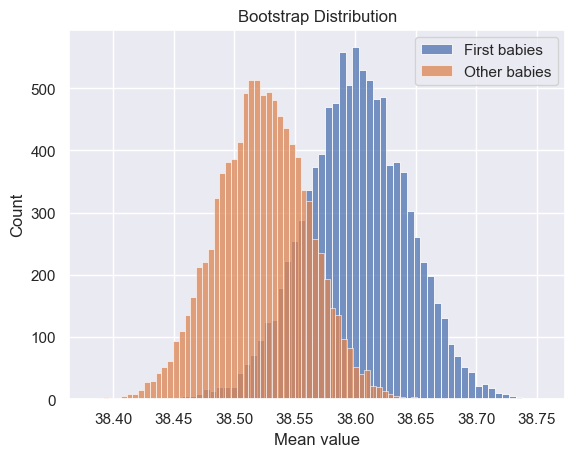

In [143]:
bs_firstpreg = stats.bootstrap((firstpreg,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')
print(bs_firstpreg.confidence_interval)

bs_otherpreg = stats.bootstrap((otherpreg,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')
print(bs_otherpreg.confidence_interval)

# Visualize the bootstrapped distribution
distribution_first = bs_firstpreg.bootstrap_distribution
distribution_other = bs_otherpreg.bootstrap_distribution
bins = 56
sns.histplot(distribution_first, bins=bins, label='First babies')
sns.histplot(distribution_other, bins=bins, label='Other babies')
plt.legend()
plt.title('Bootstrap Distribution')
plt.xlabel('Mean value');

Let's try another approach that uses the difference in means (or medians) as the test statistic for hypothesis testing. We'll generate a bootstrapped distribution for the difference in means, and if the selected confidence interval threshold includes zero, then we cannot reject the null hypothesis that there is no difference between the two datasets.

In [160]:
def two_sample_bootstrap(X, Y, stat='mean'):
    """Return bootstrapped distribution for difference in test
       statistic of two samples"""
    np.random.seed(seed=42)
    # test statistic difference
    stat_diff = []
    for _ in range(10_000):
        if stat == 'mean':
            X_mean = np.random.choice(X, size=len(X), replace=True).mean()
            Y_mean = np.random.choice(Y, size=len(Y), replace=True).mean()
        elif stat == 'median':
            X_mean = np.median(np.random.choice(X, size=len(X), replace=True))
            Y_mean = np.median(np.random.choice(Y, size=len(Y), replace=True))
        else:
            raise TypeError('Test statistic not supported.')
        stat_diff.append(X_mean - Y_mean)

    return stat_diff

In [210]:
# Compute 95% confidence intervals
means_difference = two_sample_bootstrap(firstpreg, otherpreg, stat='mean')
ci_low = np.quantile(means_difference, 0.025) 
ci_high = np.quantile(means_difference, 0.975)
print(f'95% CI for difference in means: {ci_low, ci_high}')

medians_difference = two_sample_bootstrap(firstpreg, otherpreg, stat='median')
ci_low = np.quantile(medians_difference, 0.025) 
ci_high = np.quantile(medians_difference, 0.975)
print(f'95% CI for difference in medians: {ci_low, ci_high}')

95% CI for difference in means: (-0.03150682645184748, 0.19017739658027996)
95% CI for difference in medians: (0.0, 0.0)


We can be 95% confident that the true difference in means is between -0.032 and 0.190. Since this interval contains a mean difference of 0, we cannot reject the null hypothesis that there is no difference in mean pregnancy length between first babies and other babies.

The confidence interval for difference in medians is more unexpected, but can be understood by looking at the histogram for the original data (should have done such exploratory analysis first!) shown below.

Median first pregnancy: 39.0
Median other pregnancy: 39.0


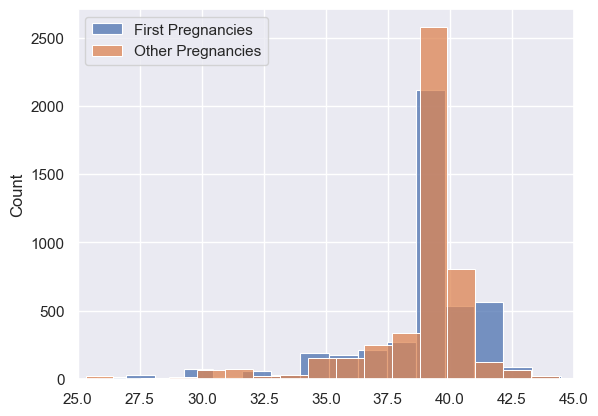

In [229]:
print(f'Median first pregnancy: {np.median(firstpreg)}')
print(f'Median other pregnancy: {np.median(otherpreg)}')

# Histogram of original data
sns.histplot(firstpreg, bins=41, label='First Pregnancies')
sns.histplot(otherpreg, bins=41, label='Other Pregnancies')
plt.xlim(25, 45)
plt.legend();

Pregnancy length does not appear to follow a normal distribution, with a length of 39 weeks being significantly more frequent across both datasets. With so many data points at that value, the median of every bootstrapped dataset falls within that same value and thus no difference in medians is observed. As a result difference in medians is not a good test statistic in this case. 